In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

In [5]:
# 1. Device setup
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [6]:
device

device(type='mps')

In [7]:
# 2. Load pretrained MobileNet model
model = torchvision.models.mobilenet_v3_large(weights="DEFAULT")
model.eval()
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /Users/danilokacanski/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 105MB/s] 


In [25]:
# 3. Load example image from Caltech-101 (replace path as needed)
img_path = "/Users/danilokacanski/Desktop/AUS Master/DL/DL/MobileNet/caltech-101/101_ObjectCategories/cellphone/image_0002.jpg"
img = Image.open(img_path).convert('RGB')

In [26]:
# 4. Define preprocessing (same as MobileNet expects)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # MobileNet expects ImageNet mean/std
        std=[0.229, 0.224, 0.225]
    )
])

input_tensor = transform(img).unsqueeze(0).to(device)

In [27]:
# 5. Forward pass to get predicted class
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

In [28]:
# 6. Create Integrated Gradients instance
ig = IntegratedGradients(model)

In [29]:
# 7. Compute attributions
attributions, delta = ig.attribute(
    input_tensor,
    target=pred_class,
    return_convergence_delta=True
)

In [30]:
# 8. Convert to numpy for visualization
input_np = input_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
input_np = np.clip((input_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406], 0, 1)

attributions_np = attributions.squeeze().cpu().permute(1, 2, 0).detach().numpy()

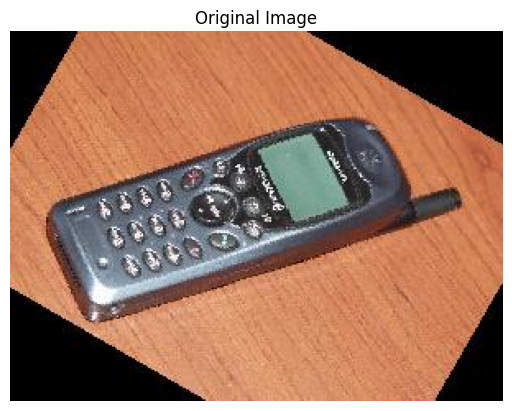

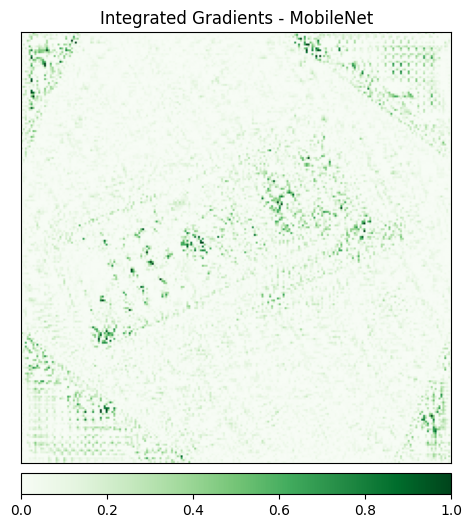

In [31]:
# 9. Visualize
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open(img_path).convert('RGB')

plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

_ = viz.visualize_image_attr(
    attributions_np,
    input_np,
    method="heat_map",
    sign="positive",
    show_colorbar=True,
    title="Integrated Gradients - MobileNet"
)